# PCFGs

 Specifically, we will use the classic example of syntactic ambiguity, namely prepositional phrase attachment: 

 1) The spy saw the professor with the telescope.
 
Start out by running out the next few cells, which provide functions that handle CFGs.


In [52]:
# Given a CFG, generates a list of all parse trees generated by that grammar
def generate_all_parses(grammar):
    rule_dict = {}

    for rule in grammar:
        parts = rule.split()
        lhs = parts[0]
        rhs = " ".join(parts[2:])
        if lhs in rule_dict:
            rule_dict[lhs].append(rhs)
        else:
            rule_dict[lhs] = [rhs]
    
    
    all_parses = ["ROOT"]
    done = 0
    
    while not done:
        new_parses = []
        
        for parse in all_parses:
            words = parse.split()
            index = 0
            
            for word in words:
                if word in rule_dict:
                    for rule in rule_dict[word]:
                        new_sent = words
                        if len(rule.split()) > 1:
                            new_sent[index] = "( " + rule + " )"
                        else:
                            new_sent[index] = rule
                        new_parses.append(" ".join(new_sent)) 
                        
                    break
                    
                if index + 1 == len(words):
                    new_parses.append(parse)
                        
                index += 1
                
        if all_parses == new_parses:
            done = 1
            
        all_parses = new_parses
        
    
    return all_parses

In [32]:
# Helper function for removing extra spaces from a string
def despace(string):
    if "  " in string:
        return despace(string.replace("  ", " "))
    return string.strip()

In [33]:
# Function that creates a dictionary of all sentences generated by a CFG and all of their possible parses
def make_parse_dict(grammar):    
    parse_dict = {}

    for parse in generate_all_parses(grammar):
        sentence = despace(parse.replace("(", "").replace(")", ""))
        if sentence in parse_dict:
            parse_dict[sentence].append(parse)
        else:
            parse_dict[sentence] = [parse]
            
    return parse_dict

**Coding Q1: Fill in the function ```parse``` below so that given a sentence and a grammar, it returns all possible ways of parsing that sentence given that grammar.**

In [34]:
def parse(sentence, grammar):
    parse_dict = make_parse_dict(grammar)
    return parse_dict[sentence]

### Ambiguity in CFGs

Now, to warm up, we need to write a CFG which can generate both possible syntactic structures for the sentence _the spy saw the professor with the telescope._ Below is such a CFG:

In [35]:
grammar_1 = ["ROOT -> S",
             "S -> NP VP .", 
             "NP -> Det N PP",
             "NP -> Det N", 
             "VP -> V NP",
             "VP -> V NP PP",
             "PP -> P Det N",
             "Det -> the", 
             "N -> spy", 
             "N -> professor", 
             "N -> telescope", 
             "N -> stopwatch",
             "P -> with", 
             "V -> saw", 
             "V -> timed"
          ]

You can use the ``parse`` function to parse sentences:

In [36]:
parse("the spy saw the professor .", grammar_1)

['( ( the spy ) ( saw ( the professor ) ) . )']

If this grammar was made correctly, and you've implemented the parse function correctly, the following line should give you both possible ways of parsing _the spy saw the professor with the telescope ._:

In [28]:
parse("the spy saw the professor with the telescope .", grammar_1)

['( ( the spy ) ( saw ( the professor ( with the telescope ) ) ) . )',
 '( ( the spy ) ( saw ( the professor ) ( with the telescope ) ) . )']

This example shows how a CFG can express ambiguity. In this case, there were two different ways that the CFG could generate this sentence, and that is where the ambiguity arose. However, even though both of these structures are possible, one is much more likely than the other. How can we express this? 

### Probabilistic CFGs

Below is a PCFG called ``pcfg_even``, which is a copy of your original CFG with a probability added to each rule. Each rule is now a 2-tuple consisting of a rule and its probability, e.g. ``("ROOT -> S", 1.0)``. To start, we have given equal probabilities to all rules that have the same left-hand side.

In [40]:
pcfg_even = [("ROOT -> S", 1.0),
             ("S -> NP VP .", 1.0), 
             ("NP -> Det N PP", 0.5),
             ("NP -> Det N", 0.5), 
             ("VP -> V NP", 0.5),
             ("VP -> V NP PP", 0.5),
             ("PP -> P Det N", 1.0),
             ("Det -> the", 1.0),
             ("N -> spy", 0.25),
             ("N -> professor", 0.25), 
             ("N -> telescope", 0.25),
             ("N -> stopwatch", 0.25),
             ("P -> with", 1.0),
             ("V -> saw", 0.5),
             ("V -> timed", 0.5)
            ]

**Coding Q2: Write versions of the functions we've seen before so that they can handle a PCFG like above. Fill in the functions below. (Hint: they should have similar structures to the non-probabilistic versions.)**

In [57]:
def generate_all_parses_pcfg(grammar):    
    rule_dict = {}

    for rule in grammar:
        parts = rule[0].split()
        lhs = parts[0]
        rhs = " ".join(parts[2:])
        if lhs in rule_dict:
            rule_dict[lhs].append((rhs, rule[1]))
        else:
            rule_dict[lhs] = [(rhs, rule[1])]
        
    #rule_dict: e.g. {'ROOT': [('VP NP', 0.8)], 'VP':[('V', 'V PP', 0.2)]}

    
    all_parses = [("ROOT", 1)]
    done = 0
    
    while not done:
        new_parses = []
        
        for parse in all_parses:
        
            
            words = parse[0].split() 
            index = 0
            
            #parse: e.g. ("ROOT (VP NP)", 0.2)
            #words: e.g. ['ROOT', 'VP', 'NP']
            
            for word in words:
                if word in rule_dict:
                    
                    probability = 1
                    for rule in rule_dict[word]:
                        
                        #rule: e.g. [('VP NP', 0.8)] or [('V', 'V PP', 0.2)]
                        
                        new_sent = words
                        
                        #replace the word with its consituency 
                        #e.g. Before replacing: words = ['ROOT']; after replacing: words = ['VP NP']
                        
                        #Example
                        #the following 4 lines take the input: {'S':['VP NP']} 
                        #and output ['S', '(VP NP)'] <-- this is an example of new_sent
                        if len(rule[0].split()) > 1:    
                            new_sent[index] = "( " + rule[0] + " )"
                        else:
                            new_sent[index] = rule[0]
                        probability = parse[1]*rule[1]
                        
                        new_parses.append((" ".join(new_sent), probability)) 
                        
                    break
                    
                if index + 1 == len(words):
                    #if we have iterated all word in words, we append the parse to the new_parses
                    #in other words, we have completed all replacing work 
                    new_parses.append(parse)
                        
                index += 1
                
        if all_parses == new_parses:
            #if no more new parses (new parse == old parse), we stop the iteration
            done = 1
            
        all_parses = new_parses
        
    
    return all_parses

In [62]:
def make_parse_dict_pcfg(grammar):  
    parse_dict = {}

    for parse in generate_all_parses_pcfg(grammar):
        sentence = despace(parse[0].replace("(", "").replace(")", ""))
        if sentence in parse_dict:
            parse_dict[sentence].append(parse)
        else:
            parse_dict[sentence] = [parse]
            
    return parse_dict

In [63]:
def parse_pcfg(sentence, grammar):
    parse_dict = make_parse_dict_pcfg(grammar)
    return parse_dict[sentence]
    

Under this formalism, the probability of an entire parse tree then becomes the product of the probabilities of all the rules used to generate that parse tree. If you try parsing sentences now, and if you have implemented the PCFG functions correctly, the result should include a probability along with the parse:

In [64]:
parse_pcfg("the spy saw the professor .", pcfg_even)

[('( ( the spy ) ( saw ( the professor ) ) . )', 0.00390625)]

In [65]:
parse_pcfg("the spy saw the professor with the telescope .", pcfg_even)

[('( ( the spy ) ( saw ( the professor ( with the telescope ) ) ) . )',
  0.0009765625),
 ('( ( the spy ) ( saw ( the professor ) ( with the telescope ) ) . )',
  0.0009765625)]

Now we can manipulate the probabilities to make one parse preferred over the other. Below we've modified ``pcfg_even`` to make ``pcfg_uneven``, which has the property that now the correct parse has a higher probability than the incorrect one.

In [66]:
pcfg_uneven = [("ROOT -> S", 1.0),
             ("S -> NP VP .", 1.0), 
             ("NP -> Det N PP", 0.1),
             ("NP -> Det N", 0.9), 
             ("VP -> V NP", 0.8),
             ("VP -> V NP PP", 0.2),
             ("PP -> P Det N", 1.0),
             ("Det -> the", 1.0),
             ("N -> spy", 0.25),
             ("N -> professor", 0.25), 
             ("N -> telescope", 0.25),
             ("N -> stopwatch", 0.25),
             ("P -> with", 1.0),
             ("V -> saw", 0.5),
             ("V -> timed", 0.5)
            ]

You can test it in the next cell:

In [67]:
parse_pcfg("the spy saw the professor with the telescope .", pcfg_uneven)

[('( ( the spy ) ( saw ( the professor ( with the telescope ) ) ) . )',
  0.0005625000000000001),
 ('( ( the spy ) ( saw ( the professor ) ( with the telescope ) ) . )',
  0.0012656250000000003)]

### Lexicalized PCFGs

Problem solved! 

...but other problems remain. What happens when you run the next cell? Does this behavior seem correct? (You don't have to answer that question - it's not graded -  but it will probably help you to think about it).

In [68]:
parse_pcfg("the spy saw the professor with the stopwatch .", pcfg_uneven)

[('( ( the spy ) ( saw ( the professor ( with the stopwatch ) ) ) . )',
  0.0005625000000000001),
 ('( ( the spy ) ( saw ( the professor ) ( with the stopwatch ) ) . )',
  0.0012656250000000003)]

The problem is that we should get different judgments depending on what the object of the preposition is, and also depending on what the verb is. Think about the following four sentences:

 1) the spy saw the professor with the telescope .
 
 2) the spy saw the professor with the stopwatch .
 
 3) the spy timed the professor with the telescope .
 
 4) the spy timed the professor with the stopwatch .

**Written Q1: For each of these four sentences, label whether the prepositional phrase (either _with the telescope_ or _with the stopwatch_) should attach to the noun (_professor_) or the verb (which is either _saw_ or _timed_).**

1) _saw_
2) _professor_
3) _professor_
4) _timed_

To solve this problem, we need to _lexicalize_ our PCFG, which means to make the rules dependent on specific words. In the next cell, we've gotten you started by lexicalizing the PPs to create a new grammar called ``pcfg_lex_v1``. Now, there are separate nonterminals for different PPs depending on what the object of the PP is. For example, ``PP_spy`` means a PP whose object is ``spy``. 

In [109]:
pcfg_lex = [("ROOT -> S", 1.0),
            ("S -> NP VP .", 1.0), 
            ("NP -> Det N PP_spy", 0.025),
            ("NP -> Det N PP_professor", 0.025),
            ("NP -> Det N PP_telescope", 0.025),
            ("NP -> Det N PP_stopwatch", 0.025),
            ("NP -> Det N", 0.9), 
            ("VP -> V NP", 0.8),
            ("VP -> V NP PP_spy", 0.05),
            ("VP -> V NP PP_professor", 0.05),
            ("VP -> V NP PP_telescope", 0.05),
            ("VP -> V NP PP_stopwatch", 0.05),
            ("PP_spy -> P Det N_spy", 1.0),
            ("PP_professor -> P Det N_professor", 1.0),
            ("PP_telescope -> P Det N_telescope", 1.0),
            ("PP_stopwatch -> P Det N_stopwatch", 1.0),
            ("Det -> the", 1.0),
            ("N -> N_spy", 0.25),
            ("N -> N_professor", 0.25),
            ("N -> N_telescope", 0.25),
            ("N -> N_stopwatch", 0.25),
            ("N_spy -> spy", 1.0),
            ("N_professor -> professor", 1.0), 
            ("N_telescope -> telescope", 1.0),
            ("N_stopwatch -> stopwatch", 1.0),
            ("P -> with", 1.0),
            ("V -> saw", 0.5),
            ("V -> timed", 0.5)
           ]

**Coding Q3: Further modify ``pcfg_lex_v1`` (by editing ``pcfg_lex`` below) so that it gives the correct judgments from your answers to Homework Q1 (that is, you should make it so that the more likely parse for each of those sentences is assigned a higher probability by ``pcfg_lex`` than the less likely parse). To do this, you may need to further lexicalize the PCFG (that is, you may need to add more word-specific nonterminals and more rules for the new nonterminals). You will also need to set the probabilities for the lexicalized rules so that the probabilities it gives result in the correct judgments for the four sentences.**

In [112]:
pcfg_lex_v1 = [("ROOT -> S", 1.0),
            ("S -> NP VP .", 1.0), 
            
            # PP Attached to NP
            ("NP -> Det N PP_spy", 0.005),
            ("NP -> Det N PP_professor", 0.005),        
            ("NP -> Det N PP_telescope", 0.045),
            ("NP -> Det N PP_stopwatch", 0.045),
               
            ("NP -> Det N", 0.9), 
               
            ("VP -> V NP", 0.8),
               
            ("VP -> V NP PP_spy", 0.01),
            ("VP -> V NP PP_professor", 0.01),
            
            # PP Attached to VP
            ("VP -> V_saw NP PP_telescope", 0.08),
            ("VP -> V_timed NP PP_telescope", 0.01),
            ("VP -> V_saw NP PP_stopwatch", 0.01),
            ("VP -> V_timed NP PP_stopwatch", 0.08),
               
            ("PP_spy -> P Det N_spy", 1.0),
            ("PP_professor -> P Det N_professor", 1.0),
            ("PP_telescope -> P Det N_telescope", 1.0),
            ("PP_stopwatch -> P Det N_stopwatch", 1.0),
            ("Det -> the", 1.0),
               
            ("N -> N_spy", 0.25),
            ("N -> N_professor", 0.25),
            ("N -> N_telescope", 0.25),
            ("N -> N_stopwatch", 0.25),
            ("N_spy -> spy", 1.0),
            ("N_professor -> professor", 1.0), 
            ("N_telescope -> telescope", 1.0),
            ("N_stopwatch -> stopwatch", 1.0),
               
            ("P -> with", 1.0),
            ("V -> V_saw", 0.5),
            ("V -> V_timed", 0.5),
            ("V_saw -> saw", 1),
            ("V_timed -> timed", 1)
           ]

If you lexicalized the grammar properly, the results you get below should match your intuitions about which parses are the correct ones for the different sentences.

In [113]:
parse_pcfg("the spy saw the professor with the telescope .", pcfg_lex_v1)

[('( ( the spy ) ( saw ( the professor ( with the telescope ) ) ) . )',
  0.0010125000000000002),
 ('( ( the spy ) ( saw ( the professor ) ( with the telescope ) ) . )',
  0.004050000000000001)]

In [114]:
parse_pcfg("the spy saw the professor with the stopwatch .", pcfg_lex_v1)

[('( ( the spy ) ( saw ( the professor ( with the stopwatch ) ) ) . )',
  0.0010125000000000002),
 ('( ( the spy ) ( saw ( the professor ) ( with the stopwatch ) ) . )',
  0.0005062500000000001)]

In [115]:
parse_pcfg("the spy timed the professor with the telescope .", pcfg_lex_v1)

[('( ( the spy ) ( timed ( the professor ( with the telescope ) ) ) . )',
  0.0010125000000000002),
 ('( ( the spy ) ( timed ( the professor ) ( with the telescope ) ) . )',
  0.0005062500000000001)]

In [116]:
parse_pcfg("the spy timed the professor with the stopwatch .", pcfg_lex_v1)

[('( ( the spy ) ( timed ( the professor ( with the stopwatch ) ) ) . )',
  0.0010125000000000002),
 ('( ( the spy ) ( timed ( the professor ) ( with the stopwatch ) ) . )',
  0.004050000000000001)]

## Garden-path sentences

The following are examples of garden-path sentences:

 1) The horse raced past the barn fell.
 
 2) All people need to buy a house is a lot of money.
 
 3) The complex houses married and single soldiers.
 
 4) The old man the boats.
 
The name _garden-path sentences_ derives from the idiom _to lead down the garden path_, which means "to mislead." In this case, these sentences mislead you because, as you hear them, you are led to believe that they should be parsed one way, but then suddenly you are forced to reconsider your assumed parse by some later words in the sentence.

Like the examples in the previous section, garden-path sentences involve ambiguity. However, there is an important difference in the types of ambiguity found in garden-path sentences vs. in _telescope_-type sentences: For the _telescope_-type sentence, the sentence has two possible parses, meaning that the sentence as a whole is ambiguous. However, for garden path sentences, there is only what is called _local ambiguity_, meaning that some subpart(s) of the sentence may be ambiguous, but once you see the whole sentence only one interpretation remains valid.

You can imagine (at least) two different general strategies for parsing a sentence. One is to start guessing the parse as you proceed from left to right, revising your parse as you encounter more words in the sentence. The other is to consider the entire sentence at once and to construct the parse based on that. The way that we are fooled by garden-path sentences argues in favor of the view that people use the incremental approach.



A crucial fact about garden-path sentences is that there is one specific point where the listener is suddenly thrown into confusion. We can appeal to probabilities to explain why this confusion arises.

Let's start out by defining a simple PCFG that can generate the horse example:

In [117]:
pcfg_garden = [("ROOT -> S", 1.0),
               ("S -> NP VP .", 1.0),
               ("NP -> Det N", 0.95),
               ("NP -> Det N Rel", 0.05),
               ("VP -> V", 0.5),
               ("VP -> V PP", 0.5),
               ("Rel -> VBN PP", 1.0),
               ("PP -> P Det N", 1.0),
               ("Det -> the", 1.0),
               ("N -> horse", 0.5),
               ("N -> barn", 0.5),
               ("V -> raced", 0.5),
               ("V -> fell", 0.5),
               ("VBN -> raced", 0.5),
               ("VBN -> taken", 0.5),
               ("P -> past", 1.0)
              ]

We're going to suppose the following: While a listener is listening to the sentence, they are constantly trying to predict which word will be uttered next. To make this prediction, the listener needs to estimate a probability distribution across all possible words. For example, suppose the listener has so far only heard _the_. In this case, it is likely that the next word will be a noun, but unlikely it will be any other part of speech - in fact, given our grammar above, no other part of speech is possible. Thus, the listener's probability distribution might look like this:

- horse: 0.5

- barn: 0.5

- the: 0.0

- raced: 0.0

- fell: 0.0

- taken: 0.0

- past: 0.0

How will the listener estimate these probabilities? We will say that they consider all possible sentences that the speaker might be uttering. To find the probability of word _w_ being the next word, the listener simply computes the total probability of all sentences in which _w_ is the next word.



To implement this, we first need a function that generates all possible sentences that can come from this CFG. Below is a function that does this.

In [118]:
def generate_all(grammar):
    
    # First, compile the grammar into a dictionary of rules
    rule_dict = {}

    for rule in grammar:
        parts = rule[0].split()
        prob = rule[1]
        lhs = parts[0]
        rhs = " ".join(parts[2:])
        if lhs in rule_dict:
            rule_dict[lhs].append((rhs, prob))
        else:
            rule_dict[lhs] = [(rhs, prob)]
    
    all_sents = [("ROOT", 1.0)]
    done = 0
    
    while not done:
        new_sents = []
        
        for sent in all_sents:
            words = sent[0].split()
            prob = sent[1]
            index = 0
            
            for word in words:
                if word in rule_dict:
                    for rule in rule_dict[word]:
                        new_sent = words
                        new_sent[index] = rule[0]
                        new_prob = prob * rule[1]
                        new_sents.append((" ".join(new_sent), new_prob)) 
                        
                    break
                    
                if index + 1 == len(words):
                    new_sents.append(sent)
                        
                index += 1
                
        if all_sents == new_sents:
            done = 1
            
        all_sents = new_sents
        
    
    return all_sents

You can see the outcome of this function with the cell below. 

In [119]:
generate_all(pcfg_garden)

[('the horse raced .', 0.11875),
 ('the horse fell .', 0.11875),
 ('the horse raced past the horse .', 0.059375),
 ('the horse raced past the barn .', 0.059375),
 ('the horse fell past the horse .', 0.059375),
 ('the horse fell past the barn .', 0.059375),
 ('the barn raced .', 0.11875),
 ('the barn fell .', 0.11875),
 ('the barn raced past the horse .', 0.059375),
 ('the barn raced past the barn .', 0.059375),
 ('the barn fell past the horse .', 0.059375),
 ('the barn fell past the barn .', 0.059375),
 ('the horse raced past the horse raced .', 0.0015625),
 ('the horse raced past the horse fell .', 0.0015625),
 ('the horse raced past the horse raced past the horse .', 0.00078125),
 ('the horse raced past the horse raced past the barn .', 0.00078125),
 ('the horse raced past the horse fell past the horse .', 0.00078125),
 ('the horse raced past the horse fell past the barn .', 0.00078125),
 ('the horse raced past the barn raced .', 0.0015625),
 ('the horse raced past the barn fell .', 

To measure how unexpected each word in the sentence is, we will use a metric called _surprisal_, which is closely related to probability. The surprisal of an event can be defined as follows, where _p_ is the probability of that event:

$s = - \log_2(p) $

Below is a function that computes surprisal given a probability.

**Coding Q4: Fill in the ```surprisal``` function below, based on the formula above.**

In [125]:
import math
def surprisal(p):
    return -math.log(p,2)

In a second, we will ask you to define a function that computes the surprisal of each subsequent word in the sentence. But first, we need to create a function which, given a grammar and a prefix (that is, the start of a sentence), returns a list of all sentences from that grammar starting with that prefix and the total probability of all those sentences.

**Coding Q5: Complete the ``possible_sentences`` function in the cell below. Its output should be list (or tuple, either is fine) with 2 elements. The first element should be a list of all sentences that start with ``prefix`` (where each sentence is represented as either a 2-element list or a 2-element tuple with the sentence as the first element and its probability as the second element. The second element of the output should be the total probability of all sentences that you return. (You can see some examples in the cells after the function definition).**

In [127]:
def possible_sentences(prefix, grammar):
    
   
    
    all_parse = generate_all(grammar)
    possible_sents = [] 
    
    total_prob = 0
    for parse in all_parse: 
        if parse[0].startswith(prefix): 
            possible_sents.append(parse)
            total_prob += parse[1]
    return possible_sents, total_prob

You can test this function will the cells below.

In [128]:
possible_sentences("the horse fell", pcfg_garden)

# This should return:
#([('the horse fell .', 0.11875),
#  ('the horse fell past the horse .', 0.059375),
#  ('the horse fell past the barn .', 0.059375)],
# 0.2375)

([('the horse fell .', 0.11875),
  ('the horse fell past the horse .', 0.059375),
  ('the horse fell past the barn .', 0.059375)],
 0.2375)

In [129]:
possible_sentences("the horse fell past", pcfg_garden)

# This should return:
# ([('the horse fell past the horse .', 0.059375),
#  ('the horse fell past the barn .', 0.059375)],
# 0.11875)

([('the horse fell past the horse .', 0.059375),
  ('the horse fell past the barn .', 0.059375)],
 0.11875)

In [130]:
possible_sentences("the horse fell .", pcfg_garden)

# This should return:
# ([('the horse fell .', 0.11875)], 0.11875)

([('the horse fell .', 0.11875)], 0.11875)

**Coding Q6: Now, fill in the ``incremental_surprisals`` function so that it returns a list of surprisals, one for each word in the sentence.

In [191]:
import math

def incremental_surprisals(sentence, grammar):
    
    words = sentence.split()
    incremental_surps = [] 
    probs = [1]
    
    for i in range(1, len(words)+1): 
        prefix = ' '.join(words[:i]) 
        
        possible_sents, prob = possible_sentences(prefix, grammar)
        probs.append(prob)
        
        #conditional probability of the next words will occurr given the previous words
        cond_prob = prob/probs[i-1]
        
        #incremental surprisal at the current word
        current_surp = round(surprisal(cond_prob),3)
        
        incremental_surps.append(current_surp)
    return incremental_surps
    
    
    

Test this function below.

In [192]:
incremental_surprisals("the horse raced .", pcfg_garden)
# This should return [-0.0, 1.0, 1.0, 1.074]

[0.0, 1.0, 1.0, 1.074]

The next cell provides a function for visualizing the surprisal at each point in the sentence. Use the cell after it to try it on some sentences. You might need to install the package matplotlib.

In [193]:
def plot_sent(sentence, rule_dict):
    sent_len = len(sentence.split())
    plt.style.use('seaborn-whitegrid')
    plt.scatter(range(sent_len), incremental_surprisals(sentence, rule_dict))
    plt.plot(range(sent_len), incremental_surprisals(sentence, rule_dict))
    plt.xticks(range(sent_len), sentence.split(), size='large')
    plt.ylim((0,6))
    plt.show()

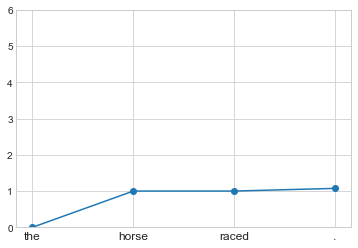

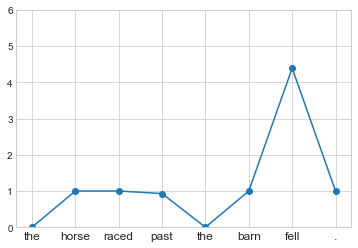

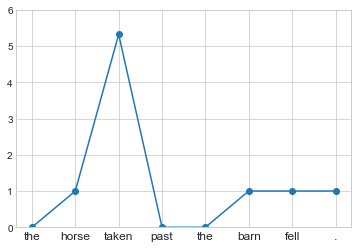

In [194]:
%matplotlib inline
import matplotlib.pyplot as plt
plot_sent("the horse raced .", pcfg_garden)
plot_sent("the horse raced past the barn fell .", pcfg_garden)
plot_sent("the horse taken past the barn fell .", pcfg_garden)

**Written Q4: Using the ``plot_sent`` function, determine the pattern of surprisals for each word in the following two sentences: "the horse raced past the barn ." and "the horse raced past the barn fell ." (If you use ``incremental_surprisals``, your answer will be a list of numerical values; if you use ``plot_sent``, your answer will be the plots that the function outputs). Explain how these patterns of surprisals illustrate the garden path effect.**

ANSWER:
The incremental surprisal remains at a realtively low level of values for the first 6 words "the horse raced past the barn fell", because in this 6 words, there is no appearace of a single word that will suddenly alter our interpretation of the parse of the sentence. However, when the 7th word "fell" apppears, our intreration on the sentence is totally changed - we suddenly realised that the substring "raced past the barn" is actually a relative clause that is attached to "the horse". Thus, the incremental surprisal suddenly surges at the word "fell", because the probability of the occurence of "fell" is quite low conditioned on the previous words. 

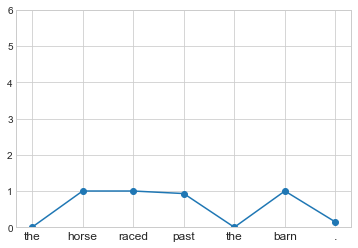

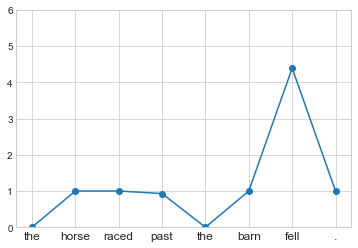

In [196]:
plot_sent("the horse raced past the barn .", pcfg_garden)
plot_sent("the horse raced past the barn fell .", pcfg_garden)

Below is a PCFG that can generate the garden path sentence "The old man the boats."

In [197]:
pcfg_boats_v1 = [("ROOT -> S", 1.0),
               ("S -> NP VP .", 1.0),
               ("NP -> Det N", 0.5),
               ("NP -> Det Adj N", 0.5),
               ("VP -> V NP", 1.0),
               ("Det -> the", 1.0),
               ("N -> old", 0.25),
               ("N -> man", 0.25),
               ("N -> children", 0.25),
               ("N -> boats", 0.25),
               ("V -> man", 0.5),
               ("V -> operate", 0.5),
               ("Adj -> old", 0.5),
               ("Adj -> elderly", 0.5)
              ]

**Coding Q7: Fill in ```pcfg_boats``` with the probabilities of the rules so that the probabilities give rise to a garden path effect, as demonstrated by the ``incremental_surprisals`` or ``plot_sent`` function. You should also make sure that no garden path effect is observed for the sentence "The children operate the boats."**

In [261]:
pcfg_boats = [("ROOT -> S", 1.0),
               ("S -> NP VP .", 1.0),
               ("NP -> Det N", 0.5),
               ("NP -> Det Adj N", 0.5),
               ("VP -> V NP", 1.0),
               ("Det -> the", 1.0),
               ("N -> old", 0.01),
               ("N -> man", 0.33),
               ("N -> children", 0.33),
               ("N -> boats", 0.33),
               
              
               ("V -> man", 0.3),
               ("V -> operate", 0.7),
              
               ("Adj -> old", 0.5),
               ("Adj -> elderly", 0.5)
              ]

You can test this grammar with the following lines, which should show a garden path effect for "the old man the boats ." but not for "the children operate the boats ."

In [262]:
incremental_surprisals("the old man the boats .", pcfg_boats)

[0.0, 1.971, 1.602, 5.807, 2.599, -0.0]

In [263]:
incremental_surprisals("the children operate the boats .", pcfg_boats)

[0.0, 2.599, 0.515, -0.0, 2.599, -0.0]

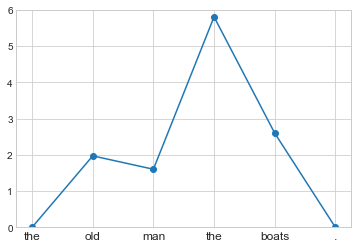

In [264]:
plot_sent("the old man the boats .", pcfg_boats)

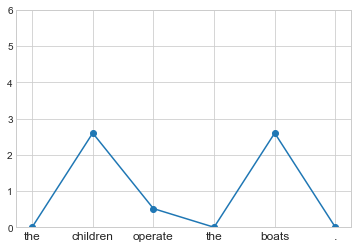

In [265]:
plot_sent("the children operate the boats .", pcfg_boats)